In [138]:
from IPython.display import display
import cv2
import math 
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
from tqdm import tqdm
import copy
import sys

In [139]:
def mark(image, component):
    """
    Draws box on image following component's measurement 
    
    image = Numpy 2D/3D
    component = (x, y, width, height)
    return = void
    """
    x, y, w, h = component
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

def markComponents(image, components):
    """
    Draws multiple boxes on image following components' measurement
    
    image = image retrived from cv2.imread('image.png')
    components = list of (x, y, width, height)
    return = void
    """
    for component in components:
        mark(image, component)

def getComponents(image):
    """
    Detects regions that may have objects using Maximally stable extremal regions(MSER)
    and return bounding boxes
    
    image =  Numpy 2D/3D
    return = list of (x,y,width,height)
    """
    mser = cv2.MSER_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
    _, boxes = mser.detectRegions(gray)
    return boxes

def colorDifference(component1, component2):
    """
    Takes two images, calculate and return the color difference using:
    
                      ____________________________________
                     /         2           2           2
   f (c  , c )  =   / (r - r )   + (g - g )  + (b - b )
        i    j    \/    i   j        i   j       i   j
        
    
    Param and Return:
    component1 = (x,y,width,height)
    component2 = (x,y,width,height)
    return = float
    """
    b1,g1,r1 = cv2.split(component1)
    b2,g2,r2 = cv2.split(component2)

    return math.sqrt( ((b2.mean()-b1.mean())**2) + ((g2.mean()-g1.mean())**2) + ((r2.mean()-r1.mean())**2))

def spatialDistance1(box1, box2):
    """
    Takes two bounding boxes, calculate and returns the spatial distance using:
    
                     v
                      ij    
    f(c , c ) = _____________
       i   j
                 min(h , h )
                      i   j
    
    
    Refer to paper in readme for symbols
    
    Param and Return:    
    box1 = (x,y,width,height)
    box2 = (x,y,width,height)
    return = float
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    return abs(y1 - y2)/min(h1,h2)

def spatialDistance2(box1, box2):
    """
    Takes two bounding boxes, calculate and returns the spatial distance using:
    
                     d
                      ij
    f(c , c ) = _____________
       i   j 
                 min(h , h )
                      i   j
    
    
    Refer to paper in readme for symbols
    
    Param and Return:   
    box1 = (x,y,width,height)
    box2 = (x,y,width,height)
    return = float
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    e = x2 + w2 if x1 > x2 else x1 + w1
    s = x1 if x1 > x2 else x2
    return abs(s-e)/min(h1,h2)

def alignment1(box1, box2):
    """
    Takes two bounding boxes, calculate and return the alignment features using:
    
                  |h - h |
                  | i   j|
    f(c , c ) = _____________
       i   j
                 min(h , h )
                      i   j
    
    Refer to paper in readme for symbols
    
    Param and Return:   
    box1 = (x,y,width,height)
    box2 = (x,y,width,height)
    return = float
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    return abs(h1-h2)/min(h1,h2)

def alignment2(box1, box2):
    """
    Takes two bounding boxes, calculate and return the alignment features using:
    
                     o
                      ij
    f(c , c ) = _____________
       i   j
                 min(h , h )
                      i   j
    
    Refer to paper in readme for symbols
    
    Param and Return:   
    box1 = (x,y,width,height)
    box2 = (x,y,width,height)
    return = float
    """
    
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    e2 = y2 + h2 if y1 > y2 else y1 + h1
    s2 = y1 if y1 > y2 else y2
    return abs(s2-e2)/min(h1,h2)

def sumDistance(w, cd, sd1, sd2, a1, a2):
    """
    Sums all features with weights using:
    
                  5
                ____
                \      T
    f(c , c ) =  \   w   f
       i   j     /        i, j, k
                /___
                k = 1
    
    Refer to paper in readme for symbols
    
    Param and Return:
    w (weights) = float
    cd (color difference) = float
    sd1 (spatial distance) = float
    a1 (alignment 1) = float
    """
    return (cd * w) + (sd1 * w) + (sd2 * w) + (a1 * w) + (a2 * w)

def getCroppedImage(box, img):
    """
    Crops image using the bounding box given
    
    Param and Return:
    box = (x,y,width,height)
    img = Numpy 2D
    return = Numpy 2D/3D
    """
    x, y, w, h = box
    return img[y:y+h, x:x+w]

def distanceFunc(weight, box1, box2, img):
    """
    Crops 2 images following the bounding boxes given. Then, calculates 
    the distance function by summing up the features in using the 
    sumDistance(w, cd, sd1, sd2, a1, a2) function.
    
    Param and Return:
    weight = float
    box1 = (x,y,weight,height)
    box2 = (x,y,weight,height)
    img = Numpy 2D/3D    
    """
    w = 5

    component1 = getCroppedImage(box1, img)
    component2 = getCroppedImage(box2, img)

    cd = colorDifference(component1, component2)

    sd1 = spatialDistance1(box1, box2)

    sd2 = spatialDistance2(box1, box2)

    a1 = alignment1(box1, box2)

    a2 = alignment2(box1, box2)

    d = sumDistance(w, cd, sd1, sd2, a1, a2)

    return d

def dictToList(dic):
    """
    Converts distance matrix from dictionary to list
    
    Param and Return:
    dic = dictionary
    return = 2D list
    """
    length = len(dic['Components'])
    dic.pop('Components', None)
    matrix = []
    for i in range(length):
        temp = []
        for key in dic:
            temp.append(dic[key][i])
        matrix.append(temp)
    return matrix

def listToDict(matrix):
    """
    Converts distance matrix from list to dictionary
    
    Param and Return:
    matrix = 2D list
    return = dictionary
    """
    ROW = 'Components'
    components = {ROW: [None] * len(boxes)}
    for i in range(len(matrix)):
        temp = []
        for j in range(len(matrix)):
            temp.append(matrix[j][i])
            components[ROW][j] = C(j)
        components[C(i)] = temp
    return components
def removeIdentical(matrix):
    """
    Removes identical values by replacing it with 0 in the distance matrix
    Example:
     __                    __
    |                        |
    |  0  1.8 3.0 2.2 4.1 9.9|
    | 1.8  0  8.0 7.0 5.7 5.2|
    | 3.0 8.0  0  4.9 9.1 1.0|
    | 2.2 7.0 4.9  0  4.5 2.8|
    | 4.1 5.7 9.1 4.5  0  0.3|
    | 9.9 5.2 1.0 2.8 0.3  0 |
    |__                    __|
    
    
    to
    
     __                    __
    |                        |
    |  0   0   0   0   0   0 |
    | 1.8  0   0   0   0   0 |
    | 3.0 8.0  0   0   0   0 |
    | 2.2 7.0 4.9  0   0   0 |
    | 4.1 5.7 9.1 4.5  0   0 |
    | 9.9 5.2 1.0 2.8 0.3  0 |
    |__                    __|
    
    
    """
    for i,row in enumerate(matrix):
        flag = False
        for j,item in enumerate(row):
            if item == 0:
                flag = True
            if flag:
                matrix[i][j] = 0
    return matrix

def findLowestValue(matrix):
    lowest = 99999999999999999
    l_row = 0
    l_column = 0
    for i,row in enumerate(matrix):
        for j,item in enumerate(row):
            if item == 0:
                break
            if item < lowest:
                lowest = item
                l_row = i
                l_column = j
    return lowest, l_row, l_column

def C(num):
    return 'C'+str(num)

def mergeComponents(components, ind1, ind2):
    comp = list(components)
    newBox = union(comp[ind1], comp[ind2])
    comp[ind1] = newBox
    comp.pop(ind2)
    return comp

def distanceMatrix(boxes, img):
    ROW = 'Components'
    components = {ROW: [None] * len(boxes)}
    w = 4

    print("Calculating distance matrix...")
    for i,box1 in enumerate(tqdm(boxes)):
        components[C(i)] = [None] * len(boxes)
        for j,box2 in enumerate(boxes):
            if j == i:
                components[C(i)][j] = 0
                components[ROW][j] = C(j)
                continue
            
            distance = distanceFunc(w, box1, box2, img)
            
            components[C(i)][j] = distance
            components[ROW][j] = C(j)

    return components

def intersects(a, b):
    return not (a.x + a.w < b.x or a.x > b.x + b.w or a.y < b.y + b.h or a.y + a.h > b.y)

def cluster(matrix, components, thres):
    
    copy_comp = copy.deepcopy(components)
    cur_matrix = copy.deepcopy(matrix)
    tar_matrix = copy.deepcopy(matrix)
    e = thres
    count = 0
    
    print("Performing Single Link Clustering...")
    
    while True:
        count = count + 1
        lowest, l_row, l_column = findLowestValue(cur_matrix)
        sys.stdout.write('\r')
        sys.stdout.write(f'Number of text candidates: {len(cur_matrix)}, Shortest distance: {lowest}, Iteration: {count}')
        sys.stdout.flush()

        if lowest >= e:
            break

        for i in range(len(tar_matrix[0])):
            c1_t = 0
            c2_t = 0

            if l_row == i or l_column == i:
                continue

            if l_row > i:
                c1_t = tar_matrix[l_row][i]
            elif l_row < i:
                c1_t = tar_matrix[i][l_row]

            if l_column > i:
                c2_t = tar_matrix[l_column][i]
            elif l_column < i:
                c2_t = tar_matrix[i][l_column]

            d = min(c1_t, c2_t)

            if l_row > i:
                cur_matrix[l_row][i] = d
            elif l_row < i:
                cur_matrix[i][l_row] = d

        cur_matrix.pop(l_column)
        for i in range(len(cur_matrix)):
            cur_matrix[i].pop(l_column)

        tar_matrix = copy.deepcopy(cur_matrix)
        
        copy_comp = mergeComponents(copy_comp, l_row, l_column)
        

    sys.stdout.write(f'\nClustering completed: {len(cur_matrix)} text candidate found.')
    sys.stdout.flush()
    return cur_matrix, copy_comp

def union(a,b):
  x = min(a[0], b[0])
  y = min(a[1], b[1])
  w = max(a[0]+a[2], b[0]+b[2]) - x
  h = max(a[1]+a[3], b[1]+b[3]) - y
  return (x, y, w, h)

def intersection(a,b):
  x = max(a[0], b[0])
  y = max(a[1], b[1])
  w = min(a[0]+a[2], b[0]+b[2]) - x
  h = min(a[1]+a[3], b[1]+b[3]) - y
  if w<0 or h<0: return () # or (0,0,0,0) ?
  return (x, y, w, h)

def combine_boxes(boxes):
    new_array = []
    for boxa, boxb in zip(boxes, boxes[1:]):
        if intersection(boxa, boxb):
            new_array.append(union(boxa, boxb))
        else:
            new_array.append(boxa)
    return np.array(new_array).astype('int')

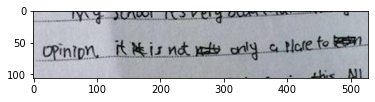

In [140]:
img = cv2.imread('sample3.png')
plt.imshow(img)
plt.show()

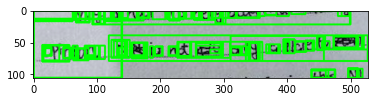

In [141]:
boxes = getComponents(img)
mser_img = img.copy()
markComponents(mser_img, boxes)
plt.imshow(mser_img)
plt.show()

In [142]:
dMatrix = distanceMatrix(boxes, img)
df = pd.DataFrame(dMatrix)
display(df)

Calculating distance matrix...


100%|██████████| 402/402 [00:09<00:00, 42.04it/s]


,Components,C0,C1,C2,C3,C4,C5,C6,C7,C8,...,C392,C393,C394,C395,C396,C397,C398,C399,C400,C401
0,C0,0.000000,9.117647,70.722885,70.722885,70.722885,70.722885,70.722885,70.722885,70.722885,...,215.259683,215.259683,215.259683,215.259683,209.238140,209.238140,209.238140,67.874216,67.874216,662.126331
1,C1,9.117647,0.000000,70.722885,70.722885,70.722885,70.722885,70.722885,70.722885,70.722885,...,215.259683,215.259683,215.259683,215.259683,209.238140,209.238140,209.238140,67.874216,67.874216,662.126331
2,C2,70.722885,70.722885,0.000000,11.176471,11.176471,11.176471,11.176471,11.176471,11.176471,...,155.048461,155.048461,155.048461,155.048461,147.597412,147.597412,147.597412,66.693430,66.693430,716.815954
3,C3,70.722885,70.722885,11.176471,0.000000,11.176471,11.176471,11.176471,11.176471,11.176471,...,155.048461,155.048461,155.048461,155.048461,147.597412,147.597412,147.597412,66.693430,66.693430,716.815954
4,C4,70.722885,70.722885,11.176471,11.176471,0.000000,11.176471,11.176471,11.176471,11.176471,...,155.048461,155.048461,155.048461,155.048461,147.597412,147.597412,147.597412,66.693430,66.693430,716.815954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,C397,211.965413,211.965413,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,...,124.580444,124.580444,124.580444,124.580444,8.636364,0.000000,8.636364,153.378271,153.378271,778.062665
398,C398,211.965413,211.965413,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,...,124.580444,124.580444,124.580444,124.580444,8.636364,8.636364,0.000000,153.378271,153.378271,778.062665
399,C399,69.957550,69.957550,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,...,223.050581,223.050581,223.050581,223.050581,152.923725,152.923725,152.923725,0.000000,8.750000,634.308403
400,C400,69.957550,69.957550,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,...,223.050581,223.050581,223.050581,223.050581,152.923725,152.923725,152.923725,8.750000,0.000000,634.308403


In [143]:
matrix = dictToList(dMatrix)
matrix = removeIdentical(matrix)
df = pd.DataFrame(listToDict(matrix))
display(df)

,Components,C0,C1,C2,C3,C4,C5,C6,C7,C8,...,C392,C393,C394,C395,C396,C397,C398,C399,C400,C401
0,C0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,C1,9.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,C2,70.722885,70.722885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,C3,70.722885,70.722885,11.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,C4,70.722885,70.722885,11.176471,11.176471,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,C397,211.965413,211.965413,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,...,124.580444,124.580444,124.580444,124.580444,8.636364,0.000000,0.000000,0.000000,0.000000,0
398,C398,211.965413,211.965413,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,150.324684,...,124.580444,124.580444,124.580444,124.580444,8.636364,8.636364,0.000000,0.000000,0.000000,0
399,C399,69.957550,69.957550,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,...,223.050581,223.050581,223.050581,223.050581,152.923725,152.923725,152.923725,0.000000,0.000000,0
400,C400,69.957550,69.957550,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,68.776763,...,223.050581,223.050581,223.050581,223.050581,152.923725,152.923725,152.923725,8.750000,0.000000,0


Performing Single Link Clustering...
Number of text candidates: 14, Shortest distance: 60.604027693416796, Iteration: 3893
Clustering completed: 14 text candidate found.

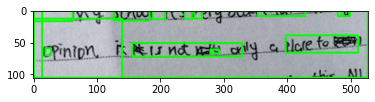

In [149]:
dMatrix, textBoxes = cluster(matrix, boxes, 60)
candidates = img.copy()
markComponents(candidates, textBoxes)
plt.imshow(candidates)
plt.show()

In [64]:
c1_t1 = matrix[208][0]
c2_t1 = matrix[207][0]
minDist = min(c1_t1, c2_t1)
print(f'The shortest distance between C208,C0 and C207,C0 is {minDist}')

The shortest distance between C208,C0 and C207,C0 is 459.6508691097668
